In [1]:
# Import essential libraries
from netCDF4 import Dataset

import numpy as np
import numpy.ma as ma
from numpy import linalg as LA

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap            
from matplotlib import colors as c
from matplotlib_scalebar.scalebar import ScaleBar

from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator

from polar_convert.constants import SOUTH
from polar_convert import polar_lonlat_to_xy

import shapefile

# data file
nc = Dataset('../amery_data/antarctica_ice_velocity_450m_v2.nc') # import the file
nc_elev = Dataset('../amery_data/BedMachineAntarctica-v3.nc') # import the elevation file

# Ice rheology
n = 3                          # Glen's flow law
A = 1.2e-25
B = 2**((n-1)/(2*n))*A**(-1/n)
delta_nu = 1e-20               # regularisation
year2sec = 3600*24*360

# latlon to Cartisian coordinate
true_scale_lat = 71            # true-scale latitude in degrees 
re = 6378.237                  # earth radius in km
ex2 = .006693883
ex = np.sqrt(ex2)              # Eccentricity of the Hughes ellipsoid
hemisphere = SOUTH

fs = 14                        # fontsize
f0 = 600
deltax=100
deltay=200

# Coordinate of the lake
lat_0 = -70.59
lon_0 = +72.53
x0 = 2030352.068563 # y-coord (m)
y0 = 638998.965875  # x-coord (m)

# # Ross
# lat_0 = -77.8
# lon_0 = +178.8
# x0,y0 = 1e3*np.array(polar_lonlat_to_xy(lon_0, lat_0, true_scale_lat, re, ex, hemisphere))


# Slice the Amery region from the whole Antarctica    
xa = x0 - 3e5
xb = x0 + 3e5
ya = y0 - 0.5e5
yb = y0 + 2.0e5
interval = 1

In [74]:
np.size(n_v)

1480740

In [2]:
# import the velocity data
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
vx = nc.variables['VX'][:]/year2sec
vy = nc.variables['VY'][:]/year2sec
xv = nc.variables['x'][:]
yv = nc.variables['y'][:]

# change y to an increasing function
yv = np.flipud(yv)
vy = np.flipud(vy)
vx = np.flipud(vx)
lon = np.flipud(lon)
lat = np.flipud(lat)

# grid size
dx = xv[1]-xv[0]
dy = yv[1]-yv[0]

# Gaussian filter
vx = gaussian_filter(vx, sigma=4, truncate=10.0)
vy = gaussian_filter(vy, sigma=4, truncate=10.0)

# import the bathymetry data
x_elev = nc_elev.variables['x'][:]
y_elev = nc_elev.variables['y'][:]
surf = nc_elev.variables['surface'][:]
bed = nc_elev.variables['bed'][:]
thickness = nc_elev.variables['thickness'][:]
mask = nc_elev.variables['mask'][:]

# change y to an increasing function
y_elev = np.flipud(y_elev)
surf = np.flipud(surf)
bed = np.flipud(bed)
thickness = np.flipud(thickness)
mask = np.flipud(mask)

# close the file
nc.close()
nc_elev.close()

# Lake position
ixl = np.argmin(np.abs(xv-x0))
iyl = np.argmin(np.abs(yv-y0))
ixl_elev = np.argmin(np.abs(x_elev-x0))
iyl_elev = np.argmin(np.abs(y_elev-y0))

print("Nearest node is ", xv[ixl],yv[iyl])
print("The lat/lon is", lat[iyl,ixl], lon[iyl,ixl])
print("Nearest node on elev map is ", x_elev[ixl_elev],y_elev[iyl_elev])
print("Lake position is ",x0,y0)

# Construct the grid for surface and bed elevation
# ===================== elevation map =========================
# index on elev map
ixa = np.argmin(np.abs(x_elev-xa))
ixb = np.argmin(np.abs(x_elev-xb))
iya = np.argmin(np.abs(y_elev-ya))
iyb = np.argmin(np.abs(y_elev-yb))

# grid to plot surface elevation
xs = x_elev[ixa:ixb]
ys = y_elev[iya:iyb]
MXs, MYs = np.meshgrid(xs,ys)
s_elev = surf[iya:iyb,ixa:ixb]
b_elev = bed[iya:iyb,ixa:ixb]
t_elev = thickness[iya:iyb,ixa:ixb]
m_elev = mask[iya:iyb,ixa:ixb]

# ===================== velocity map =========================
# index on vel map
ixva = np.argmin(np.abs(xv-xa))
ixvb = np.argmin(np.abs(xv-xb))
iyva = np.argmin(np.abs(yv-ya))
iyvb = np.argmin(np.abs(yv-yb))
# grid to plot velocity
xp = xv[ixva:ixvb:interval]
yp = yv[iyva:iyvb:interval]
vxp = vx[iyva:iyvb:interval,ixva:ixvb:interval]
vyp = vy[iyva:iyvb:interval,ixva:ixvb:interval]
v_magnitude = np.sqrt(vxp**2 + vyp**2)
MX,MY = np.meshgrid(xp,yp)

theta_v = np.angle(vxp + 1j*vyp) # velocity angle axis-2
n_v = np.array([np.cos(theta_v),np.sin(theta_v)]) # velocity direction
theta_trans = theta_v - np.pi/2.0 # transverse angle axis-1
n_trans = np.array([np.cos(theta_trans),np.sin(theta_trans)]) # transverse direction

# ===================== strain rate =========================
dx = xp[1]-xp[0]
dy = yp[1]-yp[0]
[exx,dudy]=np.gradient(vxp,dx,dy,edge_order=1)
[dvdx,eyy]=np.gradient(vyp,dx,dy,edge_order=1)
exy = 0.5*(dudy+dvdx) # shear strain rate
# calculate the deviatoric strain rate
# p = 0.5*(exx+eyy)
# exx = exx - p
# eyy = eyy - p

# strain rate in flow direction
e_parallel = n_v[0]**2*exx + 2.0*n_v[0]*n_v[1]*exy + n_v[1]**2*eyy
# strain rate perpendicular to flow
e_transverse = n_trans[0]*n_v[0]*exx + n_v[0]*n_trans[1]*exy +  n_v[1]*n_trans[0]*exy + n_v[1]*n_trans[1]*eyy
# principal strain direction
theta_p = 0.5*np.arctan(2*exy/(exx-eyy))

# ===================== deviatoric stress =========================
# eps = np.sqrt(exx*exx + 2*exy*exy + eyy*eyy)
eta = 0.5*B*((exx*exx + 2*exy*exy + eyy*eyy)+ delta_nu)**((1-n)/(2*n))
eta = eta  # viscosity in Pa yr

# stress in kPa
sigma_parallel = 2*eta*e_parallel/1e3
sigma_transverse = 2*eta*e_transverse/1e3

# ===================== grounding line =========================
# load the grounding line shapefile
sp = shapefile.Reader("../amery_data/grounding_line/InSAR_GL_Antarctica_v02.shp")
amery = 0
shapes = sp.shapes()
for i in range(len(shapes)):
        s = sp.shape(i)
        if(lon_0 > s.bbox[0] and lon_0 < s.bbox[2]) and (lat_0 > s.bbox[1] and lat_0 < s.bbox[3]):
                print(i,s.bbox)# ['%.3f' % coord for coord in s.bbox]
                amery = i

s = sp.shape(amery)
for name in dir(s):
        if not name.startswith('_'):
                print(name)
        l = np.array(s.points)
gl = np.array(s.points)   

gl_xy = []
for i,ll in enumerate(gl):
        coord = polar_lonlat_to_xy(ll[0], ll[1], true_scale_lat, re, ex, hemisphere)
        gl_xy.append(coord)
gl_xy = 1e3*np.array(gl_xy)


Nearest node is  2030300.0 639100.0
The lat/lon is -70.59017358749342 72.52698558192
Nearest node on elev map is  2030500 639000
Lake position is  2030352.068563 638998.965875


/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_98611/3633240110.py:106: RuntimeWarning: invalid value encountered in true_divide
  theta_p = 0.5*np.arctan(2*exy/(exx-eyy))


13 [68.71640014648438, -70.77486419677734, 72.88412475585938, -69.06278991699219]
bbox
parts
points
shapeType
shapeTypeName


9.626831420058197e-10


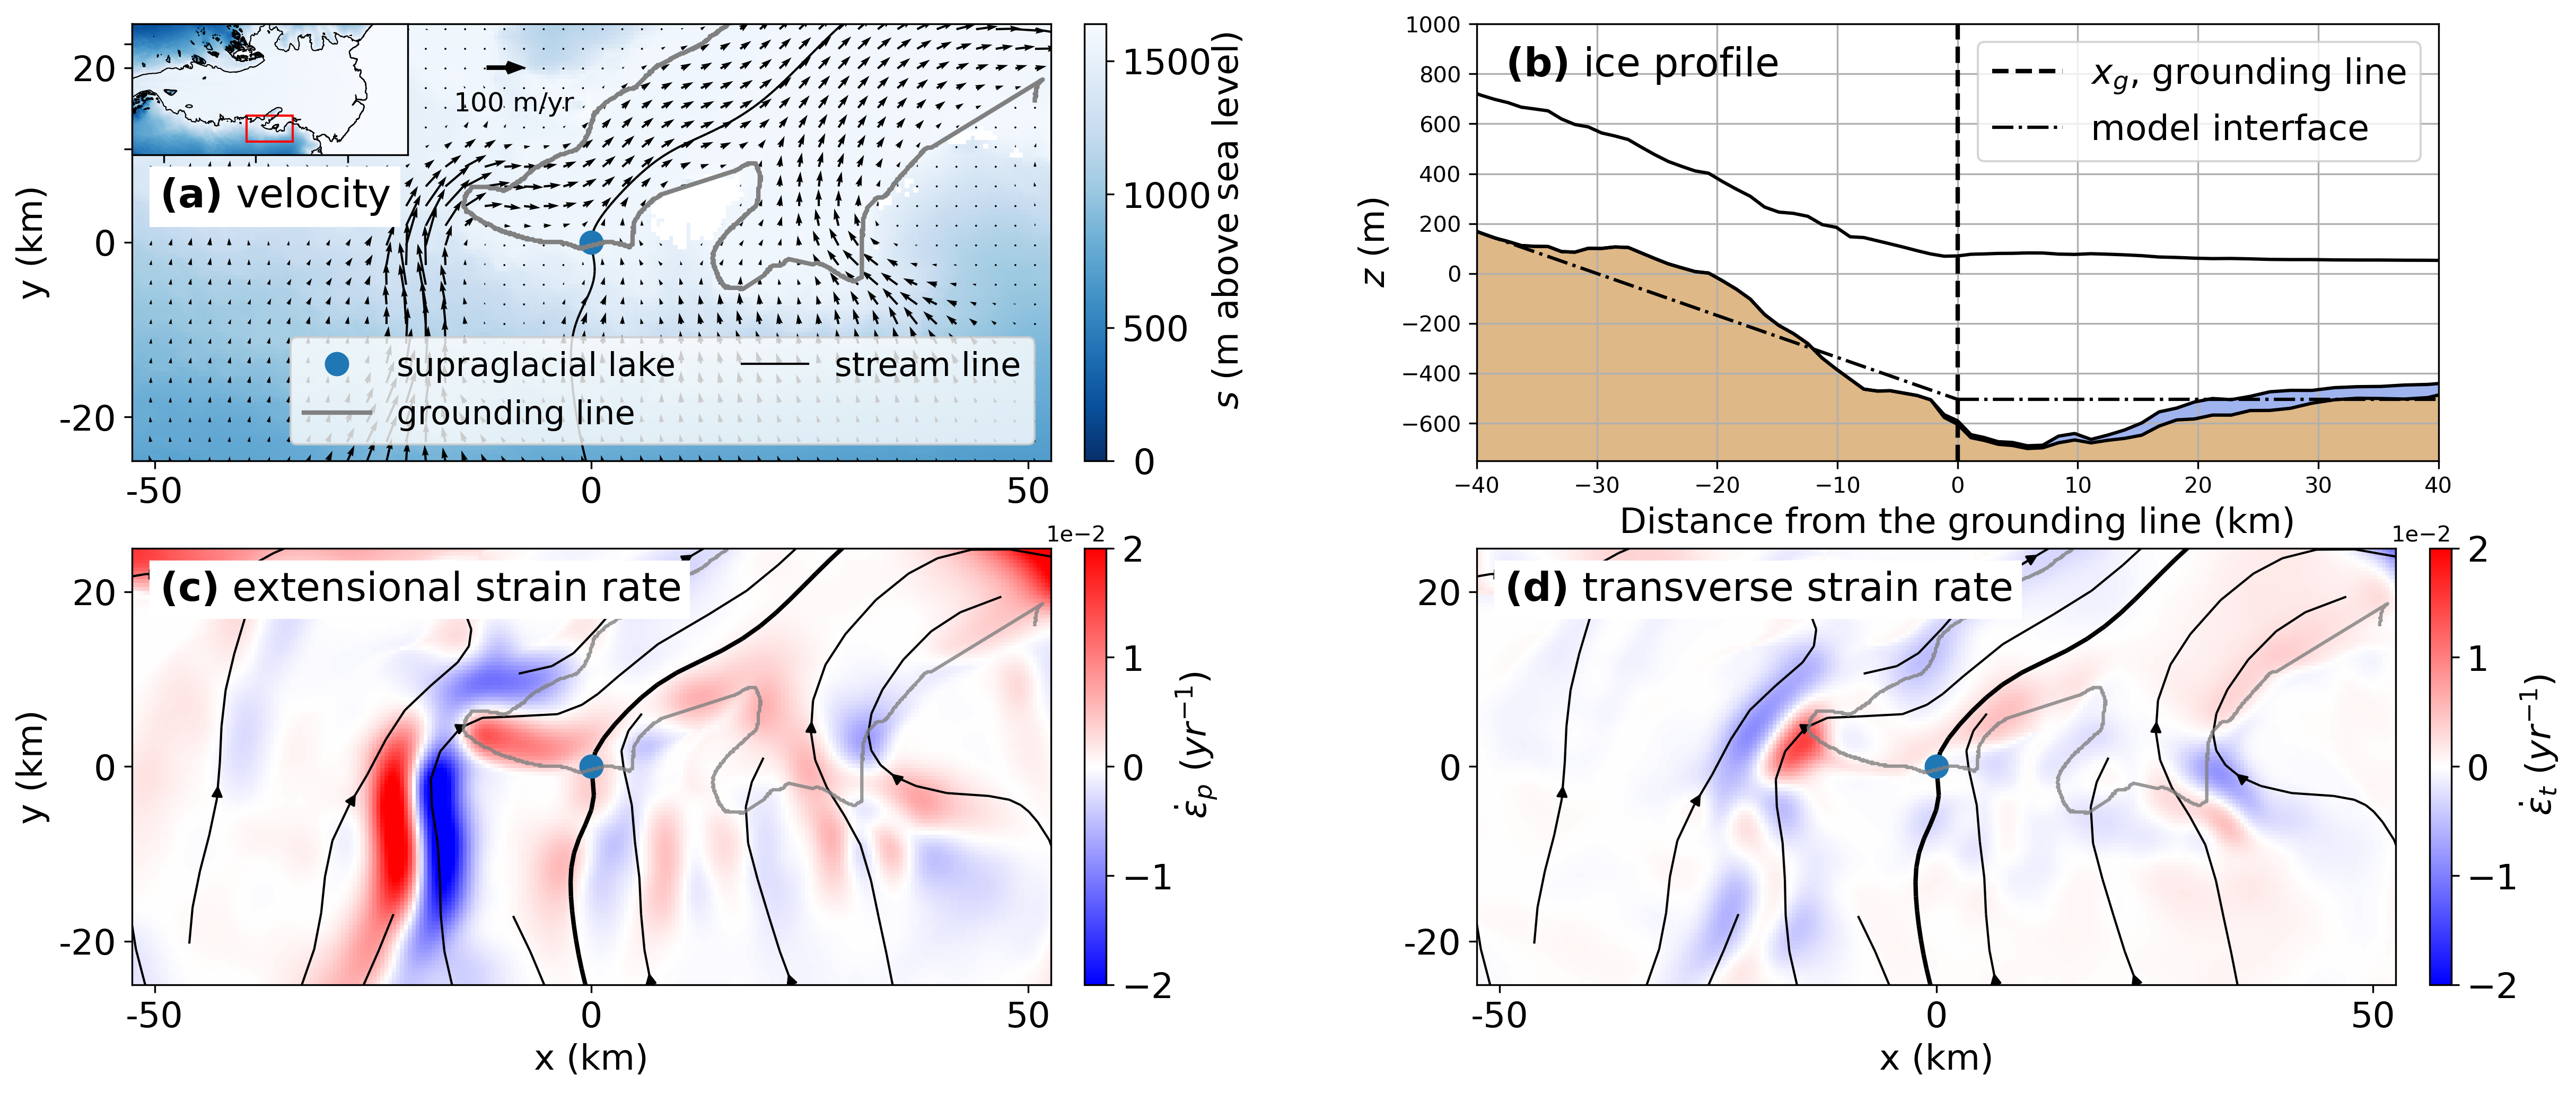

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
plt.rcParams["figure.dpi"] = 300
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
fs = 16                        # fontsize

# plt.style.use('classic')
# %config InlineBackend.figure_format = 'retina' # make high res plots for retina 5k displays

# ====================== a =========================
ax = plt.subplot(221)
text = ax.annotate(r"$\bf{(a)}$ velocity",xy=(0.03,0.58),xycoords='axes fraction',fontsize=fs+2, math_fontfamily='dejavusans')
text.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))

# exit()

# lake
lake_pos = plt.plot(x0,y0,marker='o',markersize=10, linestyle='None', label=r'supraglacial lake')
# elevation
norm = mpl.colors.Normalize(vmin=s_elev.min(), vmax=s_elev.max())
plt.pcolor(MXs,MYs,s_elev,shading='nearest',cmap='Blues',norm=norm)
# ax.contour(MXs,MYs,m_elev,levels=[1],linewidth=2.0)

# velocity field
delta = 5
plt.quiver(xp[::delta],yp[::delta],vxp[::delta,::delta]*year2sec,vyp[::delta,::delta]*year2sec, units='width',\
            scale=0.4e3, scale_units='inches')
test = m_elev
cMap = c.ListedColormap(['white'])
test = ma.masked_where(m_elev != 1, test)
ax.pcolor(MXs,MYs,test,shading='nearest',cmap=cMap)
# add a scale bar
plt.quiver(x0-1.2e4, y0+2e4, 100, 0, scale=400, scale_units='inches', color='black', width=0.005,headwidth=3, headlength=4)
textscale = ax.annotate(r"$100$ m/yr",xy=(0.35,0.8),xycoords='axes fraction',fontsize=fs-4, math_fontfamily='dejavusans')
textscale.set_bbox(dict(facecolor='white', alpha=0.0, edgecolor='white'))

# plot the grounding line
xg_xy = ax.plot(gl_xy[f0:,0],gl_xy[f0:,1], color='grey', linewidth=2.0, linestyle='-',alpha=1.0,label=r'grounding line')

# streamline past the lake
seed_points = np.array([[x0,y0]])
strm = plt.streamplot(MX, MY, vxp, vyp, density=15, color='k', linewidth=1, start_points=seed_points)

ax.plot([1e8,1e8],[1e8,1e8], linewidth=1.0, color='k', linestyle='-',alpha=1.0,label=r'stream line')

plt.axis('equal')
plt.xlim([x0-0.5e5,x0+0.5e5])
plt.ylim([y0-0.25e5,y0+0.25e5])
plt.xticks([x0-5e4,x0,x0+5e4],['-50','0','50'],fontsize=fs, math_fontfamily='dejavusans')
plt.yticks([y0-2e4,y0,y0+2e4],['-20','0','20'],fontsize=fs, math_fontfamily='dejavusans')
plt.ylabel('y (km)',fontsize=fs, math_fontfamily='dejavusans')

# colorbar
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='Blues_r'), ax=ax, format="%2.0f",\
                  location='right', pad =0.03) # ticks=[-200,-150,-100,-50,0,50,100,150,200]
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r"$s$ (m above sea level)",fontsize=fs,labelpad=0,y=0.55,math_fontfamily='dejavusans')

# legend
lgd = ax.legend(loc='lower right',fontsize=fs-1,ncol=2,numpoints=1)

# internal axis
axins = ax.inset_axes([0.0, 0.7, 0.3, 0.3], xticklabels=[], yticklabels=[])
axins.pcolor(MXs,MYs,s_elev,shading='nearest',cmap='Blues',norm=norm)
axins.contour(MXs,MYs,m_elev,levels=[1,2],linewidths=0.5,colors='k')
axins.add_patch(plt.Rectangle((x0-5e4, y0-2.5e4), 1e5, 5e4, ls="-", ec="red", fc="none"))

# ====================== (b) =========================
ax = plt.subplot(222)
# text = ax.annotate(r"$\bf{(b)}$ principal strain",xy=(0.03,0.88),xycoords='axes fraction',fontsize=fs+2, math_fontfamily='dejavusans')
# text.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))

# position of the lake
lake_pos = plt.plot(x0,y0,marker='o',markersize=10)
# surface elevation
norm = mpl.colors.Normalize(vmin=s_elev.min(), vmax=s_elev.max())
plt.pcolor(MXs,MYs,s_elev,shading='nearest',cmap='Blues_r',norm=norm)
# principal strain rate
delta = 20
print(0.10*np.max(np.abs(e_parallel)))
plt.pcolor(MXs,MYs,s_elev,shading='nearest',cmap='Blues',norm=norm)
plt.quiver(xp[::delta],yp[::delta],np.abs(e_parallel)[::delta,::delta]*np.cos(theta_p)[::delta,::delta],np.abs(e_parallel)[::delta,::delta]*np.sin(theta_p)[::delta,::delta],\
           units='width', color='red',pivot='middle',headlength=0, headaxislength=0, scale=0.10*np.max(np.abs(e_parallel)), scale_units='inches')
plt.quiver(xp[::delta],yp[::delta],np.abs(e_transverse)[::delta,::delta]*np.cos(theta_p+np.pi/2)[::delta,::delta],np.abs(e_transverse)[::delta,::delta]*np.sin(theta_p+np.pi/2)[::delta,::delta],\
            units='width', color='blue',pivot='middle',headlength=0, headaxislength=0, scale=0.10*np.max(np.abs(e_parallel)), scale_units='inches')

# add a scale bar
plt.quiver(x0-4e4, y0-1.5e4, 0.01/year2sec, 0, scale=0.10*np.max(np.abs(e_parallel)), scale_units='inches', color='black', width=0.005, headlength=0, headaxislength=0,)
# textscale = ax.annotate(r"$0.01$/yr",xy=(0.1,0.1),xycoords='axes fraction',fontsize=fs-4, math_fontfamily='dejavusans')
# textscale.set_bbox(dict(facecolor='white', alpha=0.0, edgecolor='white'))

ind1 = plt.plot(0.1,0.1,linestyle='-',color='red')
ind2 = plt.plot(0.1,0.1,linestyle='-',color='blue')
ind3 = plt.plot(0.1,0.1,linestyle='-',color='black', linewidth=2.0)

# # =========================================================================
# Get the velocity and geometry along the streamline
num_pts = len(strm.lines.get_segments())
flow_line = np.full((num_pts, 2), np.nan)
flow_line = []
for i in range(num_pts):
    dist = strm.lines.get_segments()[i][1,:] - strm.lines.get_segments()[i][0,:]
    if (LA.norm(dist)<1e-8):
        continue
    else:
        # flow_line[i,:] = strm.lines.get_segments()[i][0,:]
        flow_line.append(strm.lines.get_segments()[i][0,:])

flow_line = np.array(flow_line)

method = 'linear'
inter_vx = RegularGridInterpolator((xp, yp), vxp.T, method = method)
inter_vy = RegularGridInterpolator((xp, yp), vyp.T, method = method)
inter_v = RegularGridInterpolator((xp, yp), v_magnitude.T, method = method)
inter_epsp = RegularGridInterpolator((xp, yp), e_parallel.T, method = method)
inter_epst = RegularGridInterpolator((xp, yp), e_transverse.T, method = method)
inter_sigmap = RegularGridInterpolator((xp, yp), sigma_parallel.T, method = method)
inter_sigmat = RegularGridInterpolator((xp, yp), sigma_transverse.T, method = method)
inter_eta = RegularGridInterpolator((xp, yp), eta.T, method = method)

inter_surf = RegularGridInterpolator((xs, ys), s_elev.T, method = method)
inter_bed = RegularGridInterpolator((xs, ys), b_elev.T, method = method)
inter_mask = RegularGridInterpolator((xs, ys), m_elev.T, method = method)
inter_thickness = RegularGridInterpolator((xs, ys), t_elev.T, method = method) 

# flow_line = flow_line[::1]
v_strm = inter_v(flow_line)
eta_strm = inter_eta(flow_line)
surf_strm = inter_surf(flow_line)
bed_strm = inter_bed(flow_line)
epsp_strm = inter_epsp(flow_line)
epst_strm = inter_epst(flow_line)
sigmap_strm = inter_sigmap(flow_line)
sigmat_strm = inter_sigmat(flow_line)
thickness_strm = inter_thickness(flow_line)

# find the arclength
arclength = [0.]
s = 0
for i,node in enumerate(flow_line[1:]):
    s += LA.norm(node-flow_line[i-1])
    arclength.append(s)
arclength = np.array(arclength)
temp = (flow_line[:,0]-x0)**2 + (flow_line[:,1]-y0)**2
lake = np.argmin(np.abs((flow_line[:,0]-x0)**2 + (flow_line[:,1]-y0)**2))
arclength = arclength - arclength[lake]

start = np.argmin(np.where(arclength+50e3))
end = np.argmin(np.where(arclength-50e3))

# ====================== b =========================
# ax = plt.subplot(222)
text = ax.annotate(r"$\bf{(b)}$ ice profile",xy=(0.03,0.88),xycoords='axes fraction',fontsize=fs+2, math_fontfamily='dejavusans')
# text.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
top = ax.plot(arclength/1e3, surf_strm, linestyle='-', linewidth=1.5, color='k')
bot = ax.plot(arclength/1e3, surf_strm - thickness_strm, linestyle='-',linewidth=1.5, color='k') # marker='o'
bed = ax.plot(arclength/1e3, bed_strm, linestyle='-', linewidth=1.5, color='k')
gl = ax.axvline(x=arclength[lake]/1e3, ymin=-1e3, ymax=1e3, linestyle='--',linewidth=2, color='k',label=r'$x_g$, grounding line')
# fill in color
plt.fill_between(arclength/1e3,surf_strm - thickness_strm,bed_strm,facecolor='royalblue',alpha=0.5) # water
plt.fill_between(arclength/1e3,-1000*np.ones(np.size(arclength)),bed_strm,facecolor='burlywood',alpha=1.0) # bedrock
# approximated ice profile
xl = np.argmin(np.abs(arclength+4e4))
ax.plot([arclength[xl]/1e3,arclength[lake]], [bed_strm[xl], bed_strm[lake]+100],\
        linestyle='-.', linewidth=1.5, color='k', label=r'model interface')
ax.plot([arclength[lake]/1e3,arclength[-1]], [bed_strm[lake]+100, bed_strm[lake]+100],\
        linestyle='-.', linewidth=1.5, color='k')

ax.grid(True)
lgd = ax.legend(loc='upper right',fontsize=fs,ncol=1)
plt.xlabel(r'Distance from the grounding line (km)',fontsize=fs, math_fontfamily='dejavusans')
plt.ylabel(r'$z$ (m)',fontsize=fs, math_fontfamily='dejavusans')
plt.xlim([-40,40])
plt.ylim([-750,1000])

# ====================== c =========================
ax = plt.subplot(223)
text=ax.annotate(r"$\bf{(c)}$ extensional strain rate",xy=(0.03,0.88),xycoords='axes fraction',fontsize=fs+2, math_fontfamily='dejavusans')
text.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))

lake_pos = plt.plot(x0,y0,marker='o',markersize=10)
norm = mpl.colors.Normalize(vmin=-.02, vmax=.02)
plt.pcolor(MX,MY,e_parallel*year2sec,shading='nearest',cmap='bwr',norm=norm)

# streamline past the lake
seed_points = np.array([[x0,y0]])
strm = plt.streamplot(MX, MY, vxp, vyp, density=5, color='k', linewidth=2, start_points=seed_points)
# background streamlines
plt.streamplot(MX, MY, vxp, vyp, density=2, color='k', linewidth=1)

plt.axis('equal')
plt.xlim([x0-0.5e5,x0+0.5e5])
plt.ylim([y0-0.25e5,y0+0.25e5])
plt.xticks([x0-5e4,x0,x0+5e4],['-50','0','50'],fontsize=fs, math_fontfamily='dejavusans')
plt.yticks([y0-2e4,y0,y0+2e4],['-20','0','20'],fontsize=fs, math_fontfamily='dejavusans')
plt.ylabel('y (km)',fontsize=fs, math_fontfamily='dejavusans')
plt.xlabel('x (km)',fontsize=fs, math_fontfamily='dejavusans')

# grounding line
xg_xy = ax.plot(gl_xy[f0:,0],gl_xy[f0:,1], color='grey', linewidth=1.5, linestyle='-',alpha=0.8,label=r'grounding line')

# colorbar
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='bwr'), ax=ax,\
                  location='right', pad =0.03) # ticks=[-200,-150,-100,-50,0,50,100,150,200]
# cbar.ax.set_yticklabels([r'$-200$',r'$-150$',r'$-100$',r'$-50$',r'0',r'$50$', r'$100$',r'$150$',r'$200$'],\
#                        math_fontfamily='dejavusans')  # vertically oriented colorbar
cbar.formatter.set_powerlimits((0,1)) 
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r"$\dot{\varepsilon}_{p}$ ($yr^{-1}$)",fontsize=fs,labelpad=0,y=0.55,math_fontfamily='dejavusans')
# cbar.set_label(r"$\sigma_p$ ($kPa$)",fontsize=fs,labelpad=0,y=0.55,math_fontfamily='dejavusans')

# ====================== d =========================
ax = plt.subplot(224)
text=ax.annotate(r"$\bf{(d)}$ transverse strain rate",xy=(0.03,0.88),xycoords='axes fraction',fontsize=fs+2, math_fontfamily='dejavusans')
text.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
lake_pos = plt.plot(x0,y0,marker='o',markersize=10)
norm = mpl.colors.Normalize(vmin=-.02, vmax=.02)
plt.pcolor(MX,MY,e_transverse*year2sec,shading='nearest',cmap='bwr',norm=norm)

# streamline past the lake
seed_points = np.array([[x0,y0]])
strm = plt.streamplot(MX, MY, vxp, vyp, density=5, color='k', linewidth=2, start_points=seed_points)
# background streamlines
plt.streamplot(MX, MY, vxp, vyp, density=2, color='k', linewidth=1)

plt.axis('equal')
plt.xlim([x0-0.5e5,x0+0.5e5])
plt.ylim([y0-0.25e5,y0+0.25e5])
plt.xticks([x0-5e4,x0,x0+5e4],['-50','0','50'],fontsize=fs, math_fontfamily='dejavusans')
plt.yticks([y0-2e4,y0,y0+2e4],['-20','0','20'],fontsize=fs, math_fontfamily='dejavusans')
# plt.ylabel('y (km)',fontsize=fs, math_fontfamily='dejavusans')
plt.xlabel('x (km)',fontsize=fs, math_fontfamily='dejavusans')

# grounding line
xg_xy = ax.plot(gl_xy[f0:,0],gl_xy[f0:,1], color='grey', linewidth=1.5, linestyle='-',alpha=0.8,label=r'grounding line')

# colorbar
cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='bwr'), ax=ax,\
                  location='right', pad =0.03) # ticks=[-200,-150,-100,-50,0,50,100,150,200]
# cbar.ax.set_yticklabels([r'$-200$',r'$-150$',r'$-100$',r'$-50$',r'0',r'$50$', r'$100$',r'$150$',r'$200$'],\
#                        math_fontfamily='dejavusans')  # vertically oriented colorbar
cbar.formatter.set_powerlimits((0,1)) 
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r"$\dot{\varepsilon}_{t}$ ($yr^{-1}$)",fontsize=fs,labelpad=0,y=0.55,math_fontfamily='dejavusans')
# cbar.set_label(r"$\sigma_t$ ($kPa$)",fontsize=fs,labelpad=0,y=0.55,math_fontfamily='dejavusans')

pos_01 = axs[0][0].get_position()
pos_02 = axs[0][1].get_position()
pos_02.x1 += -0.05 
axs[0][1].set_position(pos_02)

plt.savefig('../figures/figure_7.jpeg',bbox_inches='tight',dpi=300)